In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [2]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

In [3]:
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [5]:
data.columns

Index(['time', 'close'], dtype='object')

In [6]:
data = data.drop('time',axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   294 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


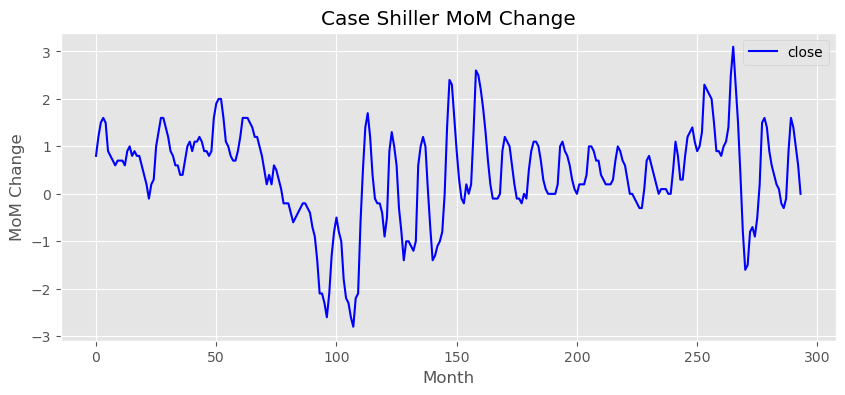

In [8]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

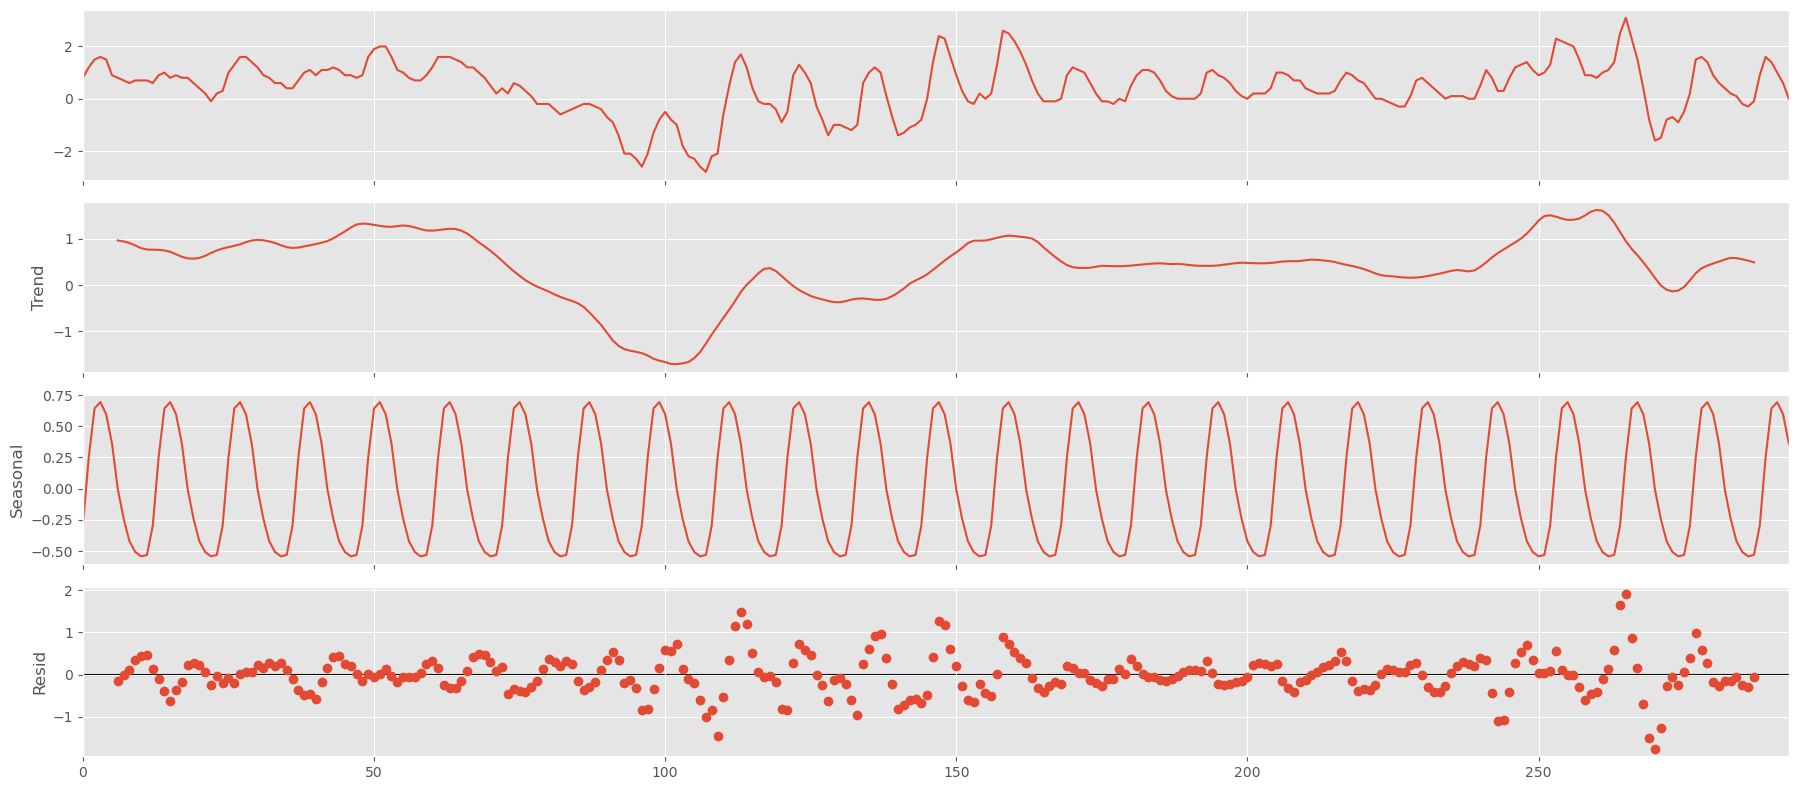

In [9]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 12)
fig = decomposition.plot()
plt.show()

In [10]:
data_raw = data.to_numpy()

In [11]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

data_scaled = scaler.fit_transform(data_raw)

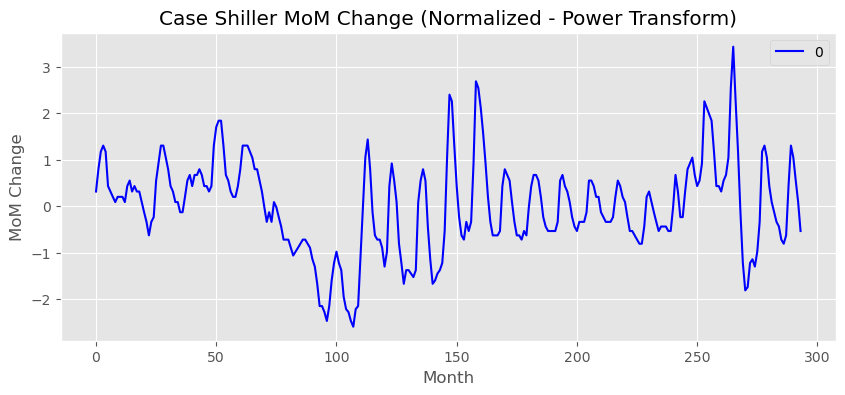

In [12]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

In [13]:
data_scaled.shape

(294, 1)

In [14]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)
number_targets = len(data) - split
data_targets = data.to_numpy()[split:]


train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(206, 1)
(88, 1)


In [15]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 100

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

/var/folders/tf/xgr43d3x3gv_27t5cflz7xz00000gp/T/ipykernel_32853/193180215.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_68u_j54pu8/croot/pytorch-select_1717607460029/work/torch/csrc/utils/tensor_new.cpp:277.)
  train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)


## Create the model and train it - Vanilla LSTM

In [16]:
print(train_x.shape)
print(train_y.shape)

torch.Size([118, 88, 1])
torch.Size([118, 1])


In [20]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [98]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])
print(df_predict)

Epoch [25/150], Loss: 0.0579
Epoch [50/150], Loss: 0.0290
Epoch [75/150], Loss: 0.0418
Epoch [100/150], Loss: 0.0291
Epoch [125/150], Loss: 0.0392
Epoch [150/150], Loss: 0.0286
     Prediction
206    1.059213
207    0.957807
208    0.777595
209    0.445629
210    0.138564
..          ...
289   -3.933375
290   -3.432470
291   -2.905565
292   -2.325318
293   -1.724847

[88 rows x 1 columns]


In [18]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [21]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 3
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [25/100], Loss: 0.0772
Epoch [50/100], Loss: 0.0539
Epoch [75/100], Loss: 0.0752
Epoch [100/100], Loss: 0.0326
Epoch [25/100], Loss: 0.0586
Epoch [50/100], Loss: 0.0405
Epoch [75/100], Loss: 0.0466
Epoch [100/100], Loss: 0.0294
Epoch [25/100], Loss: 0.0900
Epoch [50/100], Loss: 0.0523
Epoch [75/100], Loss: 0.0438
Epoch [100/100], Loss: 0.0343


In [22]:
print(final_vanilla.shape)
print(final_vanilla)

(88,)
[ 1.06962663  0.95107045  0.74472391  0.44308627  0.14727586 -0.00532478
 -0.09116159 -0.14374475 -0.17157992 -0.04398519  0.27451456  0.58021321
  0.76875988  0.75338284  0.47098024  0.09961126 -0.29060846 -0.50548515
 -0.72545295 -0.74152948 -0.82345029 -0.61167481 -0.18619724  0.23624874
  0.57186723  0.66275319  0.41086951 -0.05271917 -0.73201936 -1.28728339
 -1.57604296 -1.39305215 -1.37284213 -1.28621415 -0.89375217 -0.58179566
 -0.82919776 -0.54262721 -0.25028785  0.04469461  0.19415889  0.10559112
 -0.27596851 -0.69893487 -0.80872651 -0.49412303  0.03528741  0.33404885
  0.18079033 -0.19492498 -0.03771838  0.32107004  0.55560733  0.40427855
  0.00729377 -0.38655081 -0.4265594   0.08879938  0.56093137  0.59096288
  0.35047232 -0.00207285  0.05014521  0.4691752   0.66883933  0.49834895
  0.43567893  0.44491124  0.43771631  0.64298123  0.72564956  0.53903279
  0.15163062 -0.20429212 -0.20811711  0.05929065  0.18348117  0.0260118
  0.10078606  0.07680993  0.12448685  0.379516

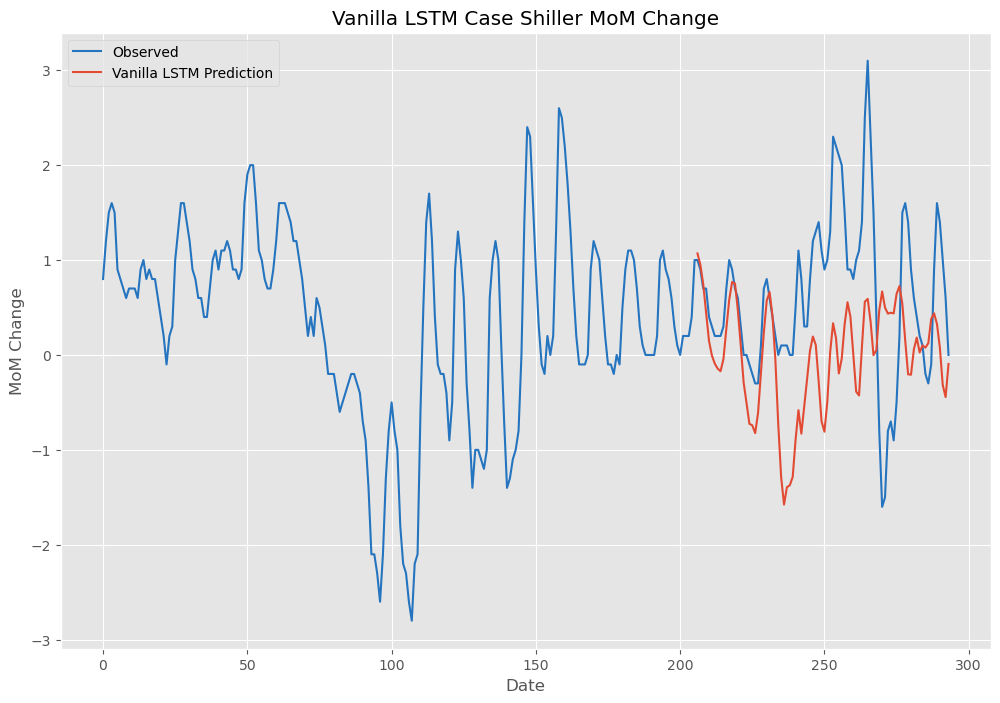

In [23]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [24]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [25]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 1.4, 'RMSE': 1.18, 'MAPE': 3128.12}

## Stacked LSTM


In [26]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
# Train and predict multiple times
n_runs = 3
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/100], Loss: 0.0508
Epoch [50/100], Loss: 0.0484
Epoch [75/100], Loss: 0.0338
Epoch [100/100], Loss: 0.0109
Epoch [25/100], Loss: 0.3265
Epoch [50/100], Loss: 0.0607
Epoch [75/100], Loss: 0.0711
Epoch [100/100], Loss: 0.0490
Epoch [25/100], Loss: 0.0772
Epoch [50/100], Loss: 0.0776
Epoch [75/100], Loss: 0.0487
Epoch [100/100], Loss: 0.0252
[ 1.07428428  0.97678213  0.85391222  0.65372347  0.46069379  0.28230609
  0.20013272  0.14750313  0.18235091  0.2691887   0.4909517   0.78313084
  0.89397907  0.83833334  0.70936317  0.49112207  0.33162633  0.1857942
  0.08023345  0.0824419   0.11617811  0.20617986  0.30309807  0.50133031
  0.60074842  0.48494544  0.19793126 -0.09403193 -0.4087603  -0.66483818
 -0.74793988 -0.89005212 -0.77454581 -0.74951657 -0.45329397 -0.16345925
 -0.06413029 -0.19904703 -0.26314173 -0.51083343 -0.67213981 -0.76100038
 -0.80799402 -0.8976802  -0.64755383 -0.61662999 -0.51744127 -0.38364369
 -0.40805901 -0.3282477  -0.38413292 -0.47568752 -0.61285958 -0.75

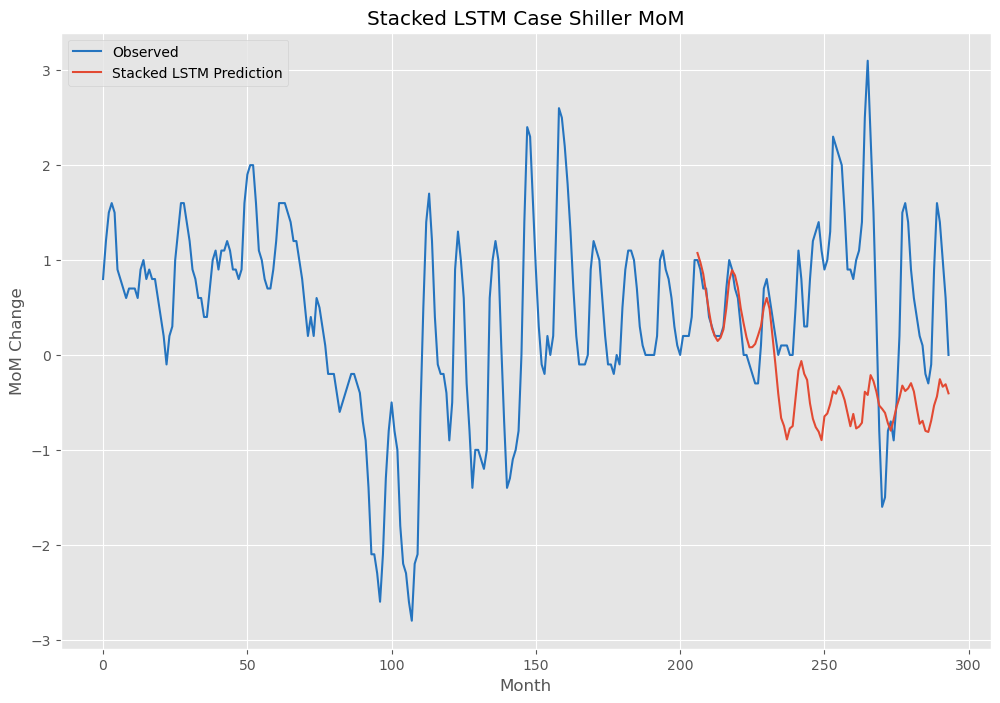

In [28]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [29]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 1.66, 'RMSE': 1.29, 'MAPE': 3604.26}